In [1]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [2]:
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import xarray as xr

sys.path.append('..')
import project

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: dv002
--------------------------------------------------------------------------


In [3]:
%autoreload
emory4dct = project.imaging.Emory4DCT('../data/Emory-4DCT')
emory4dct.load_images()

Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T00_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T10_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T20_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T30_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T40_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T50_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T60_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T70_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T80_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T90_s.img
Loading ../data/Emory-4DCT/Case2Pack/Images/case2_T00-ssm.img
Loading ../data/Emory-4DCT/Case2Pack/Images/case2_T10-ssm.img
Loading ../data/Emory-4DCT/Case2Pack/Images/case2_T20-ssm.img
Loading ../data/Emory-4DCT/Case2Pack/Images/case2_T30-ssm.img
Loading ../data/Emory-4DCT/Case2Pack/Images/case2_T40-ssm.img
Loading ../data/Emory-4DCT/Case2Pack/Images/case2_T50-ssm.img
Loading ../data/Emory-4DCT/C

<IPython.core.display.Javascript object>


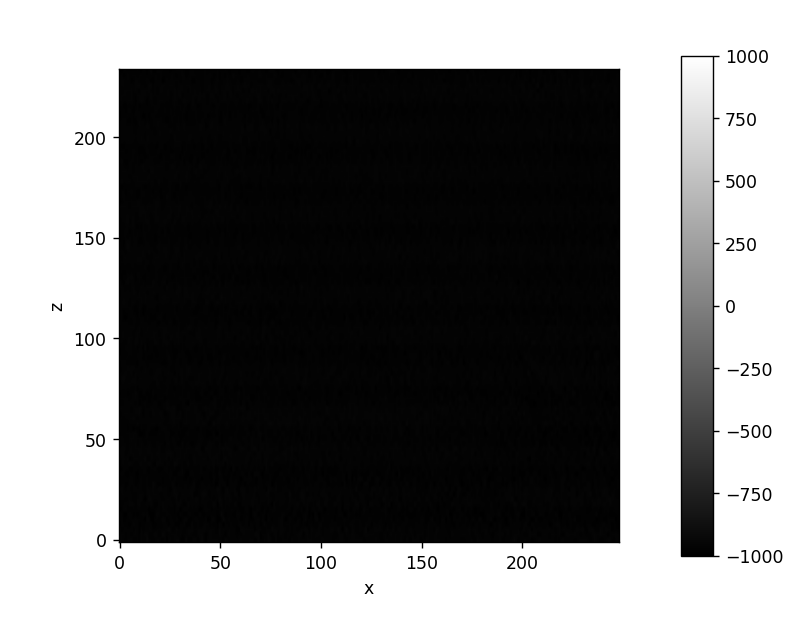

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (10, 1), (20, 2), (30, 3), (40, 4)…

<IPython.core.display.Javascript object>


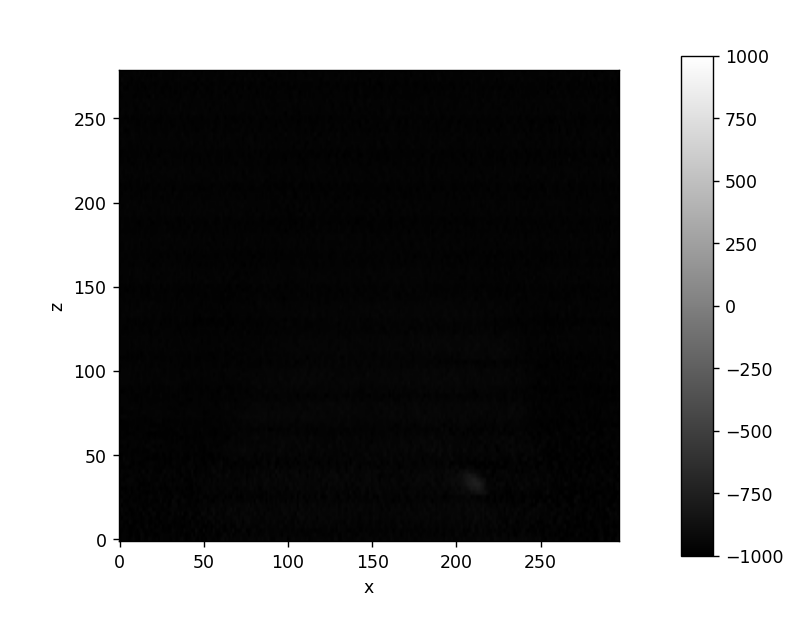

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (10, 1), (20, 2), (30, 3), (40, 4)…

In [4]:
project.visual.view(emory4dct[0].anat, x='x', y='z')
project.visual.view(emory4dct[1].anat, x='x', y='z')

In [5]:
%%time

# register all cases to case 1 at EI phase
for i in range(1, len(emory4dct)):
    case_fix = emory4dct[0]
    case_mov = emory4dct[i]
    print(f'Registering {case_mov.case_name} to {case_fix.case_name}')

    anat_fix = case_fix.anat.sel(phase=0)
    anat_mov = case_mov.anat.sel(phase=0)
    transform = project.register.register_array(
        anat_mov, anat_fix,
        learning_rate=1.0,
        num_iterations=100,
        transform='similarity'
    )
    scale = transform.GetScale()

    # apply same transformation to all phases
    all_warped = []
    for phase in emory4dct.phases:
        anat_fix = case_fix.anat.sel(phase=phase)
        anat_mov = case_mov.anat.sel(phase=phase)
        anat_warp = project.register.transform_array(
            anat_mov, anat_fix, transform, default=0
        )
        all_warped.append(anat_warp)
        
    case_mov.anat = xr.concat(all_warped, dim=case_mov.anat.phase)
    case_mov.anat.name = 'CT'

    case_mov.shape = case_fix.shape
    case_mov.resolution = [r * scale for r in case_fix.resolution]

Registering Case2Pack to Case1Pack
[level 1|iteration 0] error = 339762.6752
[level 1|iteration 10] error = 228015.1407
[level 1|iteration 20] error = 207090.6609
[level 1|iteration 30] error = 181713.5027
[level 1|iteration 40] error = 136887.8292
[level 1|iteration 50] error = 103077.5870
[level 1|iteration 60] error = 91636.2411
[level 1|iteration 70] error = 87657.8502
[level 1|iteration 80] error = 86450.3714
[level 1|iteration 90] error = 85937.8450
[level 2|iteration 0] error = 103024.4931
[level 3|iteration 0] error = 268025.8854
[level 3|iteration 10] error = 131386.7621
[level 3|iteration 20] error = 123045.7927
[level 3|iteration 30] error = 121137.8741
[level 3|iteration 40] error = 120417.5705
[level 3|iteration 50] error = 120158.8175
[level 3|iteration 60] error = 119935.4147
[level 3|iteration 70] error = 119812.9145
[level 3|iteration 80] error = 119751.2179
[level 3|iteration 90] error = 119716.8708
Registering Case3Pack to Case1Pack
[level 1|iteration 0] error = 2849

<IPython.core.display.Javascript object>


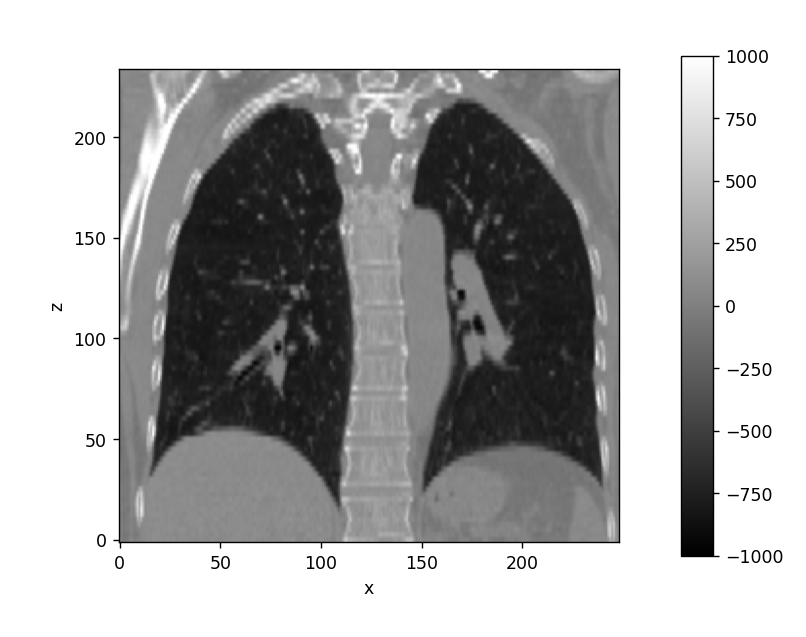

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (10, 1), (20, 2), (30, 3), (40, 4)…

<IPython.core.display.Javascript object>


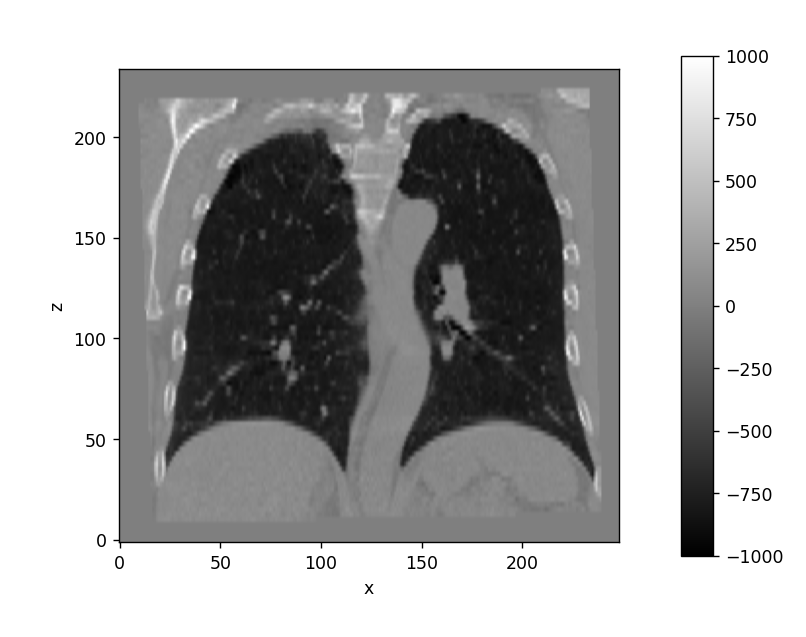

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (10, 1), (20, 2), (30, 3), (40, 4)…

In [6]:
project.visual.view(emory4dct[0].anat, x='x', y='z')
project.visual.view(emory4dct[1].anat, x='x', y='z')

In [7]:
case = emory4dct[0]
print(case.shape, case.resolution)

print(case.anat.shape)
origin = np.array([
    case.anat.x[0].values, case.anat.y[0].values, case.anat.z[0].values
])
resolution = np.array([
    case.anat.x[1].values, case.anat.y[1].values, case.anat.z[1].values
]) - origin
print(origin)
print(resolution)

(256, 256, 94) (0.97, 0.97, 2.5)
(10, 256, 256, 94)
[0. 0. 0.]
[0.97 0.97 2.5 ]


In [8]:
case = emory4dct[1]
print(case.shape, case.resolution)

print(case.anat.shape)
origin = np.array([
    case.anat.x[0].values, case.anat.y[0].values, case.anat.z[0].values
])
resolution = np.array([
    case.anat.x[1].values, case.anat.y[1].values, case.anat.z[1].values
]) - origin
print(origin)
print(resolution)

(256, 256, 94) [1.2978426350801986, 1.2978426350801986, 3.3449552450520583]
(10, 256, 256, 94)
[0. 0. 0.]
[0.97 0.97 2.5 ]


In [9]:
emory4dct.save_niftis()

Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T10.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T20.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T30.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T40.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T60.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T70.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T80.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T90.nii.gz
Saving ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T00.nii.gz
Saving ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T10.nii.gz
Saving ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T20.nii.gz
Saving ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T30.nii.gz
Saving ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T40.nii.gz
Saving ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T50.nii.gz
Saving ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T60.nii.